<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Подготовка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Подготовка данных
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#2.1-Загрузка-данных">
                            <span class="toc-item-num">2.1&nbsp;&nbsp;</span>
                            Загрузка данных
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#2.2-Разделение-на-выборки">
                            <span class="toc-item-num">2.2&nbsp;&nbsp;</span>
                            Разделение на выборки
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#3-KNeighborsClassifier">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    KNeighborsClassifier
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Weighted-KNN">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Weighted KNN
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-STOLP">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            STOLP
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Профиль-компактности">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Профиль компактности
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#5-Метод-парзеновского-окна">
                    <span class="toc-item-num">5&nbsp;&nbsp;</span>
                    Метод парзеновского окна
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#6-Embedding-над-изображениями">
                    <span class="toc-item-num">6&nbsp;&nbsp;</span>
                    Embedding над изображениями
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#6.1-Обучение-модели">
                            <span class="toc-item-num">6.1&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#6.2-Тестирование-модели">
                            <span class="toc-item-num">6.2&nbsp;&nbsp;</span>
                            Тестирование модели
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#7-Общий-вывод">
                    <span class="toc-item-num">7&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Лабораторная работа № 1: Метрические алгоритмы

**Задача:** проработать задачи с применением метрических алгоритмов:

1. Применить метод ближайших соседей (KNN): взвешенный и STOLP.
2. Построить профиль компактности.
3. Произвести оптимизацию по выбору ширины окна / Применить метод меняющегося окна.
4. Построить Embedding над изображениями (приложить к изображениям, чтобы каждой соответствовал вектор - применить в любом виде KNN для формирования датасета из векторов).
5. Подать на вход обученной на изображениях модели свои изображения.

**Источники данных:** 

* `sklearn.datasets.make_classification()` (задачи 1-3)
* [food-11 Image Classification Dataset](https://www.kaggle.com/datasets/imbikramsaha/food11?resource=download) (задача 4)
* папка `data/lab_01_images/` (задача 5)

**Описание данных:** 

* сгенерированный набор данных с 5 классами (задачи 1-3)
* фотографии еды с 11ю категориями (мини-версия датасета food-101) (задача 4)
* изображения (задача 5)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture no-display
!pip install kaggle

Импорт необходимых библиотек:

In [2]:
import numpy as np
import pandas as pd

from typing import List
import os
import kaggle
import zipfile as zf
from zipfile import ZipFile

import torch

from scipy.spatial.distance import cdist

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from utils.plot_charts import plot_class, plot_corr, create_decision_regions_gif, \
                              save_plot, plot_value, plot_random_image
from utils.useful_funcs import walk_through_dir

Скрытие предупреждений:

In [3]:
import warnings
warnings.filterwarnings('ignore')

Фиксация случайных величин:

In [4]:
SEED = 42

np.random.seed(SEED)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Подготовка данных

### 2.1 Загрузка данных

Формирование многоклассового набора данных:

In [5]:
X, Y = make_classification(
    n_samples=1000, 
    n_features=5, 
    n_informative=4, 
    n_classes=5, # lab case
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=SEED
)

Формирование датафрейма из набора данных:

In [6]:
data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
data['class'] = pd.Series(Y)

Выведение на экран первых пяти строк набора данных:

In [7]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,class
0,0.408996,0.661415,-0.897567,-1.555497,-0.904534,0
1,1.327643,1.432874,0.513679,0.297825,-1.866038,4
2,-0.732133,-2.353074,-0.558209,-0.710792,-0.377599,0
3,-3.348879,-0.881846,1.796324,-0.055609,-0.680817,0
4,0.204606,0.334694,-0.007583,-0.981608,-2.019593,1


Построение условного графика, демонстрирующего количество классов:

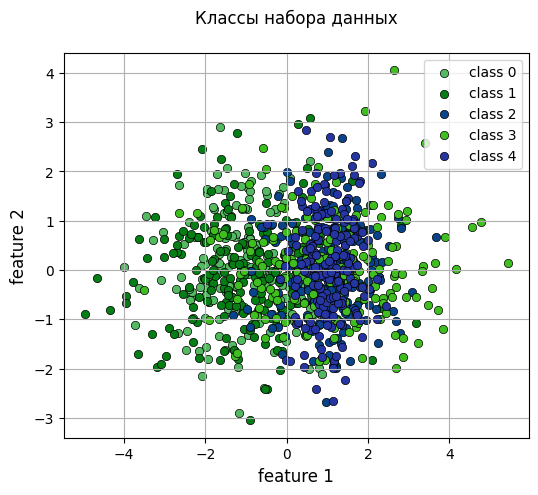

In [8]:
plot_class(data, 'Классы набора данных')

>Классы наслаиваются друг на друга.

Выведение на экран матрицы корреляции признаков набора данных:

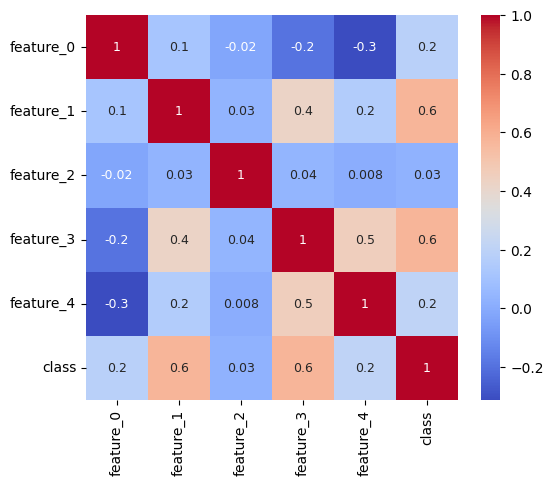

In [9]:
plot_corr(data)

>Заметно наличие корреляции между некоторыми признаками и целевым признаком.

---

### 2.2 Разделение на выборки

Разделение набора данных на тренировочную и тестовую выборки:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=SEED)

Выведение на экран размерностей выборок:

In [11]:
print('Train set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Train set shape: (750, 5)
Test set shape: (250, 5)


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 KNeighborsClassifier

**Метод ближайших соседей** — простейший метрический классификатор, основанный на оценивании сходства объектов. Классифицируемый объект относится к тому классу, которому принадлежат ближайшие к нему объекты обучающей выборки.

>**Метрический классификатор** — алгоритм классификации, основанный на вычислении оценок сходства между объектами.

$$ a(u) = arg \displaystyle\max_{y \in Y} \sum_{i=1}^k \Big[ y_u^{(i)} = y \Big] $$

где:

* $ u $ - классифицируемый объект

* $ k $ - количество соседей

* $ y $ - метка класса

* $ y_u^{(i)} $ - метка класса объекта

---

### 3.1 Weighted KNN

**Метод K взвешенных ближайших соседей** - метрический алгоритм классификации, основанный на оценивании сходства объектов. Классифицируемый объект относится к тому классу, которому принадлежат ближайшие к нему объекты обучающей выборки и учитывает расстояния до соседних объектов (увеличивает вклад близких объектов и уменьшает - далёких).

$$ a(u) = arg \displaystyle\max_{y \in Y} \sum_{i=1}^k \Big[ y_u^{(i)} = y \Big] w(i, u) $$

где:

* $ u $ - классифицируемый объект

* $ k $ - количество соседей

* $ y $ - метка класса

* $ y_u^{(i)} $ - метка класса объекта

* $ w(i, u) $ - заданная весовая функция, которая оценивает степень важности $ i $-го соседа для классификации объекта $ u $

>Особенность назначения весов индикаторам: веса тем больше, чем ближе объект к целевому.

**Достоинства:**

* Простота реализации.
* Проведённую алгоритмом классификацию легко интерпретировать путём предъявления нескольких ближайших объектов.

**Недостатки:**

* Хранит всю выборку целиком: расход памяти + чрезмерное усложнение решающего правила.
* Поиск ближайшего соседа предполагает сравнение классифицируемого объекта со всеми объектами выборки, что требует линейного по длине выборки числа операций.

*Source code: https://github.com/andriygav/MachineLearningSeminars/blob/master/sem4/main.ipynb*

---

Задание функции для расчёта весов:

In [ ]:
def func(distance: np.array) -> np.array:
    ret = np.ones_like(distance)
    k = ret.shape[1]
    
    for i in range(k):
        ret[:, i] *= (k-i) / k
        
    return ret

Сохранение моделей обучения:

In [ ]:
models_knn = []

for n_neighbors in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=func)
    model.fit(X_train, y_train)
    models_knn.append(model)

Выведение на экран этапов классификации в зависимости от количества соседей:

In [ ]:
create_decision_regions_gif(
    models=models_knn, 
    X=X_test, 
    Y=y_test, 
    title='Weighted KNN', 
    params=['n_neighbors']
)

---

### 3.2 STOLP

**Алгоритм СТОЛП** (STOLP) — алгоритм отбора эталонных объектов для метрического классификатора.

При классификации объектов метрическим классификатором необходимо вычислять расстояния от классифицируемого объекта до всех объектов обучающей выборки, а это:

* Время, затрачиваемое на вычисления для каждого объекта и пропорциональное размеру обучающей выборки.
* Объём хранимых данных.

Алгоритм предназначен для уменьшения объёма обучающей выборки, оставляя в ней только эталонные объекты для каждого класса.

**Результат работы алгоритма** - разбиение всего множества объектов на эталонные, шумовые (выбросы) и неинформативные объекты.

>**Эталоны** - наиболее типичные представители классов:
>
>* Неинформативные объекты, при удалении которых из обучающей выборки качество классификации не изменится.
>* Выбросы /шумовые объекты — объекты, находящиеся в гуще «чужого» класса, только ухудшающие качество классификации).


$$ W(x_i) = -M(x_i, \Omega) = Гy_i - \displaystyle\max_{y \in Y} Гy(x_i) $$

где:

* $ W(x_i) $ - отступ на объекте $ x_i $
* $ \Omega $ - множество эталонов
* $ Гy_i $ - комбинаторный множитель объекта

**Достоинства:**

* Хранение уменьшенной выборки = уменьшение расхода памяти.

**Недостатки:**

* Имеет относительно низкую эффективность ($ ~ O(l^2) $): на каждой итерации для присоединения очередного эталона необходимо заново классифицировать все объекты, ещё не ставшие эталонами и считать на них величину риска.

**Алгоритм STOLP**

*Вход:*

* Выборка
* Допустимая доля ошибок
* Порог отсечения выбросов
* Алгоритм классификации
* Формула для вычисления величины риска

*Описание алгоритма:*

1. Отбросить выбросы (объекты выборки с величиной риска > порога отсечения выбросов).

2. Сформировать начальное приближение множества эталонов: из объектов выборки выбрать по одному объекту каждого класса, обладающему среди объектов данного класса максимальной величиной риска либо минимальной величиной риска.

3. Наращивание множества эталонов (пока число объектов выборки, распознаваемых неправильно, не станет меньше допустимой доли ошибок):

    * Классифицировать объекты выборки, используя в качестве обучающей выборки множество эталонов.
    * Пересчитать величины риска для всех объектов выборки \ множества эталонов с учётом изменения обучающей выборки.
    * Среди объектов каждого класса, распознанных неправильно, выбрать объекты с максимальной величиной риска и добавить их ко множеству эталонов.

*Source code: https://github.com/andriygav/MachineLearningSeminars/blob/master/sem4/main.ipynb*

---

In [29]:
def compute_margins(xkd, x, y, u, u_ans, n):
    result = []
    bound = min(n, y.shape[0])
    for cur_i, cur_u in enumerate(u):
        idx = xkd.query(cur_u, bound)[1]
        maj = {}
        for i in idx:
            y_cur = y[i, 0]
            di = np.linalg.norm(cur_u - x[i])
            dn = np.linalg.norm(cur_u - x[idx[bound - 1]])
            w = 0.0
            if di != 0.0 and dn > di:
                w = dn / di
            maj[y_cur] = maj.get(y_cur, 0) + w
        cur_u_ans = [u_ans[cur_i]][0][0]
        correct_score = maj.get(cur_u_ans, 0)
        del maj[cur_u_ans]
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1]
        result.append(correct_score - max_wrong)
    return np.array(result)

In [30]:
model_knn = KNeighborsClassifier(n_neighbors=7)
model_knn.fit(X_test, y_test)

KNeighborsClassifier(n_neighbors=7)

In [31]:
margins = compute_margins(model, X_test, y_test, X_test, y_test, 7)

AttributeError: 'KNeighborsClassifier' object has no attribute 'query'

In [ ]:
len(margins)

In [ ]:
def stolp(src_x, src_y, err_num, th, n):
    #Step 2
    support_x = []
    support_y = []
    src_xkd = KDTree(src_x)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    #Step 3
    x = src_x[margins[:, 0] > th]
    y = src_y[margins[:, 0] > th]
    margins = margins[margins[:, 0] > th]
    ss = np.argsort(margins[:, 0])
    #Step 4
    for ans in np.unique(y):
        for m in ss:
            if y[m] == ans:
                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
    errors = x.shape[0]
    #Step 5
    while errors > err_num:
        xkd = KDTree(np.array(support_x))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        errors = sum(classify(np.array(support_x), np.array(support_y), src_x, n) != src_y[:, 0])
        print(errors)
        ss = np.argsort(margins)
        to_delete = []
        m = ss[0]
        support_x.append(x[m])
        support_y.append(y[m])
        to_delete.append(m)
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
    return np.array(support_x), np.array(support_y)

In [ ]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, err_num=60, depth_limit=0.0001, n=5)

In [ ]:
stolp_prx

In [ ]:
x = list(range(len(M)))
plt.plot(x, M)

plt.hlines(0, 0, len(x), color='black')
plt.fill_between(x, M, where=M<0, color='red', alpha=0.5)
plt.fill_between(x, M, where=M>0, color='green', alpha=0.5)
plt.show()

In [ ]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)
colors=['blue', 'orange']

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
for k in np.unique(Y_train):
    ax[1].plot(X_train[Y_train==k, 0], 
               X_train[Y_train==k, 1], '.', color=colors[k])
    

for ind in Omega:
    ax[1].scatter([X_train[ind, 0]], 
                  [X_train[ind, 1]], color=colors[Y_train[ind]])
    
plot_decision_regions(X_test, Y_test, model, ax=ax[0])

plt.show()


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Профиль компактности

**Профиль компактности** выборки в метрических алгоритмах классификации — функция, выражающая долю объектов выборки, для которых правильный ответ не совпадает с правильным ответом на $ j $-м соседе.

>Профиль компактности является формальным выражением **гипотезы компактности** — предположения о том, что схожие объекты гораздо чаще лежат в одном классе, чем в разных. 
>
>Чем проще задача, то есть чем чаще близкие объекты оказываются в одном классе, тем сильнее «прижимается к нулю» начальный участок профиля.

$$ R(j, X^m) = \frac {1}{m} \sum_{i=1}^m \Big[ y_i \neq y_{j, x_i} \Big] $$

где:

* $ R(j) $ - доля объектов выборки, для которых $ j $-й сосед лежит в другом классе 
* $ m $ - длина выборки

*Source code: https://github.com/andreitsev/stuff/blob/master/space_compactness_profile.py*

---

Задание функции профиля компактности:

In [ ]:
def compactness_profile(model, X: np.ndarray, Y: np.ndarray) -> np.array:
    distances, indexes = model.kneighbors(X)
    
    misclassification_fraction = []
    
    for neighbour_num in range(1, X.shape[0]):
        misclassification_fraction.append((Y != Y[indexes[:, neighbour_num]]).mean())
        
    return np.array(misclassification_fraction)

---

Обучение модели:

In [ ]:
model_cp = KNeighborsClassifier(n_neighbors=X_train.shape[0], metric='euclidean')
model_cp.fit(X_train, y_train)

Выведение на экран графика профиля компактности:

In [ ]:
plot_value(compactness_profile(
    model_cp, X_train, y_train), 
    'Доля несовпадающих объектов', 
    x_axis='n_neighbors', 
    y_axis='ratio'
)

Выведение на экран классификации:

In [ ]:
save_plot(
    index=0,
    model=model_cp, 
    X=X_train,
    Y=y_train,
    params=['n_neighbors'],
    title='Compactness Profile',
    show=True
)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 5 Метод парзеновского окна

**Метод парзеновского окна** — метод байесовской классификации, основанный на непараметрическом восстановлении плотности по имеющейся выборке.

В основе подхода лежит идея о том, что плотность выше в тех точках, рядом с которыми находится большое количество объектов выборки.

>**Байесовский классификатор** — широкий класс алгоритмов классификации, основанный на принципе максимума апостериорной вероятности. 
>
>Для классифицируемого объекта вычисляются функции правдоподобия каждого из классов, по ним вычисляются апостериорные вероятности классов. Объект относится к тому классу, для которого апостериорная вероятность максимальна.
>
>**Апостериорная вероятность** – измеряет вероятность какого-то определенного состояния окружающего мира (при котором произошло другое событие). 

$$ a(x, X^l, h) = arg \displaystyle\max_{y \in Y} \lambda_y \sum_{i=1}^l \Big[ y_i = y \Big] K \Big( \frac {p(x, x_i)}{h} \Big) $$

где:

* $ \lambda_y $ - коэффициент
* $ l $ - длина выборки

**Функция ядра (окна)** - произвольная четная функция.

Название | Функция
-|-
Прямоугольное ядро | $$ K(z) = \frac {1}{2} \Big[ |z| < 1 \Big] $$
Гауссовское ядро | $$ K(z) = \frac {1}{\sqrt{2 \pi}} exp \Big( - \frac {z^2}{2} \Big) $$
Треугольное ядро | $$ K(z) = \Big( 1 - |z| \Big) \Big[ |z| \leq 1 \Big] $$
Квартическое ядро | $$ K(z) = \frac {15}{16} \Big( 1 - z^2 \Big)^2 \Big[ |z| \leq 1 \Big] $$
Ядро Епанечникова | $$ K(z) = \frac {3}{4} \Big( 1 - z^2 \Big) \Big[ |z| \leq 1 \Big] $$

\* *Вид функции окна не влияет на качество классификации определяющим образом.*

**Ширина окна** - влияет на качество восстановления плотности и, как следствие, классификации.

**Проблемы алгоритма:**

* *Проблема локальных сгущений* - возникает в тех случаях, когда распределение объектов в пространстве сильно неравномерно, и одно и то же значение ширины окна h приводит к чрезмерному сглаживанию плотности в одних местах, и недостаточному сглаживанию в других. Проблему решают окна переменной ширины.

* *Проблема «проклятия размерности»* - если число признаков велико и учитываются все они, то все объекты оказываются примерно на одинаковом расстоянии друг от друга. Выход заключается в понижении размерности с помощью преобразования пространства признаков, либо путём отбора информативных признаков.

*Source code: https://github.com/andriygav/MachineLearningSeminars/blob/master/sem4/main.ipynb*

---

Задание функции ядра:

In [ ]:
def K(distance: np.array, h: float) -> np.array:
    ret = np.array(distance) / h
    return (1 - ret ** 2) * (np.abs(ret) <= 1)

---

Сохранение моделей обучения:

In [ ]:
for i, h in enumerate(np.arange(0.05, 3.1, 0.2)):
    model = KNeighborsClassifier(n_neighbors=len(X_train), weights=lambda x: K(x, h=h))
    model.fit(X_train, y_train)
    
    save_plot(
        index=i,
        model=model, 
        X=X_train,
        Y=y_train,
        params={'h': h},
        title='Parzen Window'
    )

Выведение на экран этапов классификации в зависимости от количества соседей:

In [ ]:
create_decision_regions_gif(title='Parzen Window', images_saved=True)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 6 Embedding над изображениями

---

### 6.1 Обучение модели

In [ ]:
def get_classes(target_dir: str) -> List[str]:
    classes = []
    
    for dirpath, dirnames, filenames in os.walk(target_dir):
        if 'train' not in dirnames and 'test' not in dirnames and dirnames != []:
            classes.extend(dirnames)
    
    return list(set(classes))

---

Добавление папки с наборами данных:

In [ ]:
if os.path.isdir('data') == False:
    os.mkdir('data')

Скачивание набора данных:

In [ ]:
if os.path.isdir('data/food11') == False:
    os.chdir('data/')
    
    !kaggle datasets download -d imbikramsaha/food11
    
    with zf.ZipFile('food11.zip', 'r') as file:
        file.extractall('.')
        
    os.remove('food11.zip')
    
    os.chdir('..')

Задание путей до тренировочного и тестового набора данных:

In [ ]:
path_data = 'data/food11/'
path_train = path_data + 'train/'
path_test = path_data + 'test/'

Выведение на экран изображения и его параметров:

In [ ]:
plot_random_image(path_train, depth='*/*')

In [ ]:
walk_through_dir(path_data)

In [ ]:
get_classes(path_data)

In [ ]:
model = timm.create_model("resnet18", pretrained=True)
model = model.eval()
X_image = []
Y_image = []

In [ ]:
val_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2(),
    ]
)

In [ ]:
for i, c in enumerate(clas):
    for j in os.listdir(data_sors + "/" + c):
        try:
            image = Image.open(os.path.join(data_sors, c, j))
            image = val_transforms(image=np.array(image))["image"]
            X_image.append(model(image.unsqueeze(0)).detach().numpy()[0])
            Y_image.append(i)
        except:
            print(os.path.join(data_sors, c, j))

---

### 6.2 Тестирование модели

Проверить на собственных фото

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 7 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>